[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HashimHilal-QUT/LLM/blob/main/AI%20Bank%20Statement%20Analyzer/AI_Bank_Statement_Analyzer.ipynb)

# **AI Based Bank Statement Analyzer**


This tool uses AI to analyze Bank Statements and give a summary of the Income and Expenses. It further classifies expenses and gives a visual summary.

In [42]:
!pip install pypdf -q



### Note:
Users can upload their Bank Statement (PDF) format and let the AI tool analyze and visualize the statement transactions. Note that this will run on Google Colab and all user data will be stored temporary in User's Colab environment, which is secured by the User's personal Google Account.

The Data is ephemeral and gets deleted as soon as the Runtime is restarted or Notebook closed


In [ ]:
import io
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from xml.dom import minidom
from pypdf import PdfReader
from google.colab import ai

def read_pdf_content(file_input):
    """
    Reads content from a file, handling both PDF bytes and text.

    Args:
        file_input: A dictionary from files.upload() or bytes content for PDF,
                    or a string for text content.

    Returns:
        str: The extracted text content.
    """
    file_content = ""
    if isinstance(file_input, dict):
        # Assuming it's from files.upload()
        filename = next(iter(file_input))
        if filename.lower().endswith('.pdf'):
            pdf_file = io.BytesIO(file_input[filename])
            pdf_reader = PdfReader(pdf_file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                file_content += page.extract_text() + "\n"
        else:
            file_content = file_input[filename].decode('utf-8')
    elif isinstance(file_input, bytes):
        # Assume it's raw PDF bytes
        pdf_file = io.BytesIO(file_input)
        pdf_reader = PdfReader(pdf_file)
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            file_content += page.extract_text() + "\n"
    elif isinstance(file_input, str):
        # Assume it's raw text content
        file_content = file_input
    else:
        raise ValueError("Unsupported file_input type.")
    return file_content

def convert_text_to_xml(text_content):
    """
    Converts raw text content into a pretty-printed XML string.

    Args:
        text_content (str): The text content to embed in XML.

    Returns:
        str: The pretty-printed XML string.
    """
    root = ET.Element("document")
    content_element = ET.SubElement(root, "content")
    content_element.text = text_content
    xml_string = ET.tostring(root, 'utf-8')
    pretty_xml = minidom.parseString(xml_string).toprettyxml(indent="  ")
    return pretty_xml

def create_llm_prompt(xml_content):
    """
    Constructs a detailed LLM prompt string for transaction extraction.

    Args:
        xml_content (str): The XML content containing financial transactions.

    Returns:
        str: The complete LLM prompt string.
    """
    llm_prompt = f"""You are an expert at extracting financial transaction data from unstructured text. Your task is to process the provided XML content, which contains a financial transaction listing, and extract specific details for each transaction.\n\nHere is the XML content:\n{xml_content}\n\nFor each transaction, you need to extract the following fields:\n- **Date**: The date of the transaction (e.g., '28 Nov 25').\n- **Particulars**: A detailed description of the transaction.\n- **Debits**: The amount debited from the account. If no debit amount is present for a transaction, set this value to `null`.\n- **Credits**: The amount credited to the account. If no credit amount is present for a transaction, set this value to `null`.\n- **Balance**: The account balance after the transaction, including the 'CR' (Credit) or 'DR' (Debit) indicator if present.\n\nYour output must be a JSON array, where each element is a JSON object representing a single transaction. Each transaction object should have the keys: `Date`, `Particulars`, `Debits`, `Credits`, and `Balance`.\n\n**Important Considerations:**\n1.  Ignore all lines that are not transaction entries. This includes headers, footers, summary information, account details, and legal disclaimers.\n2.  Ensure that `Debits` and `Credits` are extracted correctly. A transaction will typically have either a `Debits` value or a `Credits` value, but not both simultaneously for the primary transaction value. If a value is missing, use `null`.\n3.  The 'Particulars' field should capture all descriptive text associated with the transaction, excluding the date and financial amounts.\n4.  The 'Date' should only be the main transaction date, not any dates embedded within the particulars.\n5.  The 'Balance' should include the 'CR' or 'DR' suffix.\n\n**Example of how to process transaction lines:**\n\n**Input Line (from XML content):**\n`28 Nov 25 V0103 26/11 COCACOLAEPP MORNINGSID\\n74564725331 $4.60 $3,214.11 CR`\n**Expected JSON Object:**\n```json\n{{\n  \"Date\": \"28 Nov 25\",\n  \"Particulars\": \"V0103 26/11 COCACOLAEPP MORNINGSID 74564725331\",\n  \"Debits\": \"$4.60\",\n  \"Credits\": null,\n  \"Balance\": \"$3,214.11 CR\"\n}}\n```\n\n**Input Line (from XML content):**\n`10 Dec 25 WAGES/SAL D TECHNOLOGY  $5,555.55 $10,000.00 CR`\n**Expected JSON Object:**\n```json\n{{\n  \"Date\": \"10 Dec 25\",\n  \"Particulars\": \"WAGES/SAL D TECHNOLOGY \",\n  \"Debits\": null,\n  \"Credits\": \"$5,555.55\",\n  \"Balance\": \"$10,000.00 CR\"\n}}\n```\n\n**Input Line (from XML content):**\n`12 Dec 25 HASHIM HILAL F1350028108 HASHIM COMMBANK $5,555.55 $4,444.45 CR`\n**Expected JSON Object:**\n```json\n{{\n  \"Date\": \"12 Dec 25\",\n  \"Particulars\": \"HASHIM HILAL F1350028108 HASHIM COMMBANK\",\n  \"Debits\": \"$5,555.55\",\n  \"Credits\": null,\n  \"Balance\": \"$4,444.45 CR\"\n}}\n```\n\n**Examples of lines to IGNORE (do NOT include in output):**\n- `<document>`\n- `<content>`\n- `Transaction Listing`\n- `Date Created: Dec 27, 2025 1:17:43 PM`\n- `Account Balance Summary`\n- `Opening Balance $10,000.00 CR`\n- `Total Credits $25,000.00`\n- `Total Debits $15,000.00`\n- `Closing Balance $20,000.00 CR`\n- `Transaction Details`\n- `Date Particulars Debits Credits Balance`\n- `Page 1 Of 4`\n- `Important`\n- `This provisional list is not a statement of account.`\n- `National Australia Bank Limited ABN 12 004 044 937 AFSL and Australian Credit Licence 230686`\n\nReturn ONLY the JSON array. Do not include any additional text, explanations, or formatting outside of the JSON.\n"""
    return llm_prompt

def extract_transactions_from_xml(llm_prompt):
    """
    Sends the LLM prompt to ai.generate_text and returns the raw response.

    Args:
        llm_prompt (str): The constructed LLM prompt string.

    Returns:
        str: The raw response string from the LLM.
    """
    response = ai.generate_text(llm_prompt)
    return response

def clean_and_convert_dataframe(llm_response_string):
    """
    Parses LLM response, converts to DataFrame, and cleans/converts data types.

    Args:
        llm_response_string (str): The raw LLM response string.

    Returns:
        pd.DataFrame: The cleaned and type-converted DataFrame.
    """
    # Extract JSON string, handling markdown formatting
    if llm_response_string.startswith('```json') and llm_response_string.endswith('```'):
        json_string = llm_response_string[len('```json'):-len('```')].strip()
    else:
        json_string = llm_response_string.strip()

    transaction_data = json.loads(json_string)
    df = pd.DataFrame(transaction_data)

    def clean_financial_value(value):
        if isinstance(value, str):
            cleaned_value = value.replace('$', '').replace(',', '').strip()
            if cleaned_value == '':
                return np.nan
            return float(cleaned_value)
        return value

    df['Debits'] = df['Debits'].apply(clean_financial_value).astype(float)
    df['Credits'] = df['Credits'].apply(clean_financial_value).astype(float)

    def convert_balance_to_numeric(balance_str):
        if isinstance(balance_str, str):
            balance_str = balance_str.replace('$', '').replace(',', '').strip()
            if balance_str == '':
                return np.nan

            # Use regex to separate value from 'CR'/'DR'
            match = re.match(r'([\d.]+)\s*(CR|DR)?', balance_str)
            if match:
                value = float(match.group(1))
                indicator = match.group(2)
                if indicator == 'DR':
                    return -value
                return value
            return np.nan # If no match, return NaN
        return balance_str

    df['Balance'] = df['Balance'].apply(convert_balance_to_numeric).astype(float)

    def convert_date_to_full_year(date_str):
        if pd.isna(date_str) or date_str is None:
            return np.nan
        parts = date_str.split(' ')
        if len(parts) != 3:
            return np.nan # Handle malformed date strings
        day = int(parts[0])
        month = parts[1]
        year_short = int(parts[2])

        # Assume years '00'-'49' are 2000s, and '50'-'99' are 1900s
        if year_short >= 50:
            full_year = 1900 + year_short
        else:
            full_year = 2000 + year_short
        return f"{day} {month} {full_year}"

    df['Date'] = df['Date'].apply(convert_date_to_full_year)
    df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y')

    return df

def generate_transaction_plot(df):
    """
    Generates a line plot of Debits and Credits over time.

    Args:
        df (pd.DataFrame): The DataFrame containing 'Date', 'Debits', 'Credits' columns.

    Returns:
        matplotlib.figure.Figure: The generated matplotlib Figure object.
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    sns.lineplot(x='Date', y='Debits', data=df, marker='o', label='Debits', ax=ax)
    sns.lineplot(x='Date', y='Credits', data=df, marker='x', label='Credits', ax=ax)

    ax.set_title('Transaction Debits and Credits Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Amount ($)')
    ax.legend()
    plt.xticks(rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    return fig

def process_bank_statement(file_input):
    """
    Processes a bank statement PDF file to extract transactions, clean data,
    and generate a plot of debits and credits over time.

    Args:
        file_input: A file path string, bytes content (for PDF), or a dictionary
                    from files.upload() for PDF/text files.

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The cleaned and type-converted DataFrame of transactions.
            - matplotlib.figure.Figure: The generated matplotlib Figure object.
    """
    # 1. Read content from the file
    print("Step 1: Reading content from the input file...")
    text_content = read_pdf_content(file_input)
    if not text_content:
        raise ValueError("Could not extract any text content from the input file.")
    print("Content read successfully.")

    # 2. Convert extracted text to XML
    print("Step 2: Converting text content to XML format...")
    xml_content = convert_text_to_xml(text_content)
    print("Text converted to XML successfully.")

    # 3. Create LLM prompt
    print("Step 3: Creating LLM prompt for transaction extraction...")
    llm_prompt = create_llm_prompt(xml_content)
    print("LLM prompt created successfully.")

    # 4. Extract transactions using LLM
    print("Step 4: Sending prompt to LLM and extracting transactions...")
    llm_response_string = extract_transactions_from_xml(llm_prompt)
    if not llm_response_string:
        raise ValueError("LLM did not return any response.")
    print("Transactions extracted by LLM successfully.")

    # 5. Clean and convert DataFrame
    print("Step 5: Cleaning and converting extracted transaction data...")
    df_transactions = clean_and_convert_dataframe(llm_response_string)
    if df_transactions.empty:
        raise ValueError("No transactions were parsed into the DataFrame.")
    print("DataFrame cleaned and converted successfully.")

    print("Displaying the extracted and cleaned transaction DataFrame:")
    print(df_transactions.to_markdown(index=False))

    # 6. Generate transaction plot
    print("Step 6: Generating transaction plot...")
    fig_plot = generate_transaction_plot(df_transactions)
    print("Transaction plot generated.")

    print("Bank statement processing complete.")
    return df_transactions, fig_plot


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

# Upload the PDF file
print("Please upload your bank statement PDF file:")
uploaded_files = files.upload()

# Check if a file was uploaded
if not uploaded_files:
    print("No file was uploaded. Please try again.")
else:
    # Process the uploaded file using the defined function
    # The 'uploaded_files' dictionary contains the filename and its content (bytes)
    df_transactions_processed, fig_transactions_plot = process_bank_statement(uploaded_files)

    print("\n--- Processed Transactions DataFrame ---")
    print(df_transactions_processed.head())

    print("\n--- Displaying Transaction Plot ---")
    plt.show(fig_transactions_plot)


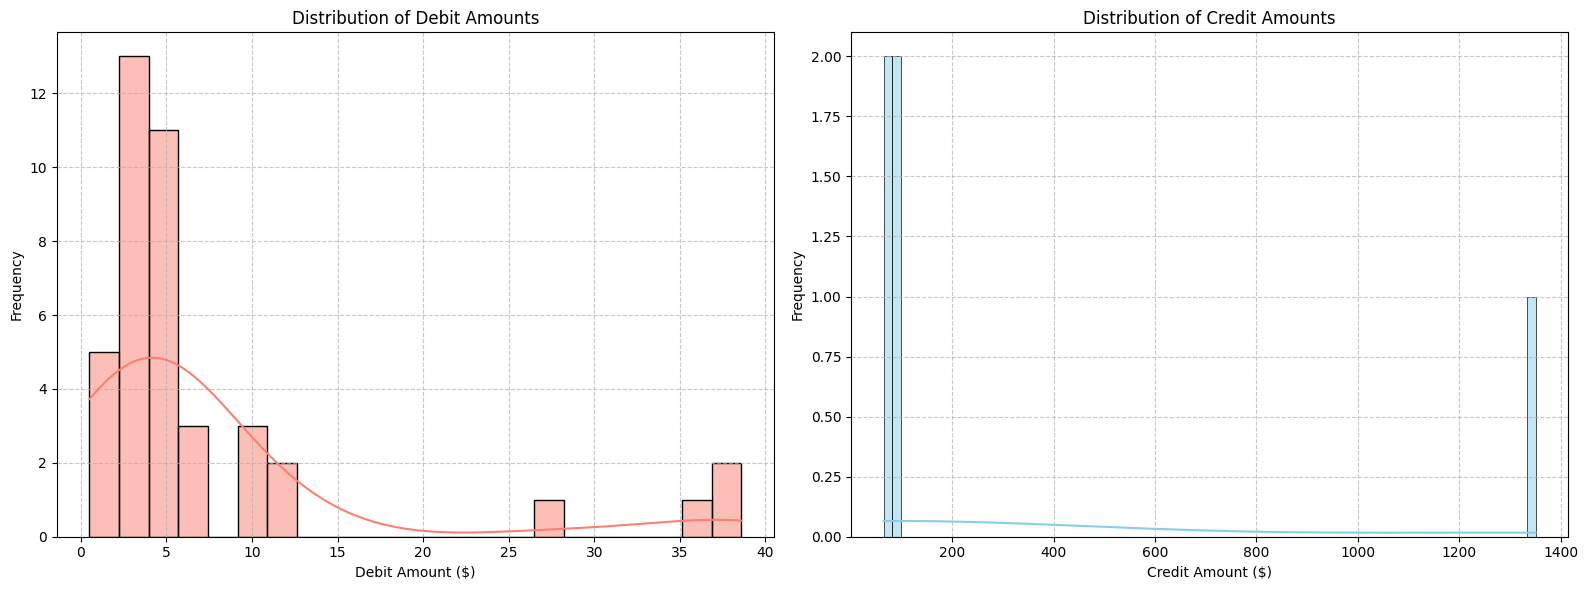

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots for debits and credits distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot distribution of Debits
sns.histplot(df_transactions_processed['Debits'].dropna(), kde=True, ax=axes[0], color='salmon')
axes[0].set_title('Distribution of Debit Amounts')
axes[0].set_xlabel('Debit Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot distribution of Credits
sns.histplot(df_transactions_processed['Credits'].dropna(), kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Distribution of Credit Amounts')
axes[1].set_xlabel('Credit Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Layout adjustments
plt.tight_layout()
plt.show()


In [ ]:
transactions_for_llm = []

for index, row in df_transactions_processed.iterrows():
    date = row['Date'].strftime('%Y-%m-%d') # Format date as YYYY-MM-DD
    particulars = row['Particulars']
    debits = row['Debits']
    credits = row['Credits']

    if pd.notna(debits):
        transaction_string = f"Date: {date}, Particulars: {particulars}, Expense: {debits:.2f}"
    elif pd.notna(credits):
        transaction_string = f"Date: {date}, Particulars: {particulars}, Income: {credits:.2f}"
    else:
        transaction_string = f"Date: {date}, Particulars: {particulars}, Amount: N/A"

    transactions_for_llm.append(transaction_string)

print(f"Prepared {len(transactions_for_llm)} transaction strings for LLM classification.")
# Display the first 5 formatted transaction strings to verify
print("\nFirst 5 formatted transaction strings:")
for i, transaction_str in enumerate(transactions_for_llm[:5]):
    print(f"{i+1}. {transaction_str}")

In [47]:
classification_categories = [
    'Grocery', 'Restaurant', 'Transport', 'Utilities', 'Salary', 'Rent',
    'Shopping', 'Entertainment', 'Cash Withdrawal', 'Bank Fees', 'Transfer',
    'Other Expense', 'Other Income'
]

categories_str = ', '.join(f"'{cat}'" for cat in classification_categories)

transactions_llm_string = '\n'.join(transactions_for_llm)

llm_classification_prompt = f"""Your task is to classify a list of financial transactions into one of the predefined categories.

Here is the list of categories: {categories_str}.

For each transaction, you need to output a JSON object containing the 'Transaction String' and its assigned 'Category'.

**Instructions:**
1.  Carefully analyze the 'Particulars' and the 'Amount' (Expense/Income) for each transaction.
2.  Assign the most appropriate category from the provided list to each transaction.
3.  Note that 'Expense' amounts correspond to debit transactions, and 'Income' amounts correspond to credit transactions.
4.  If a transaction clearly falls into an income category (e.g., 'Income'), classify it as 'Other Income' or 'Salary' if explicit.
5.  If a transaction clearly falls into an expense category, choose the most specific expense category.
6.  If no specific category fits well for an expense, use 'Other Expense'.

**Input Transactions:**
{transactions_llm_string}

**Output Format (JSON array of objects):**
```json
[
  {{
    "Transaction String": "Date: 2025-11-27, Particulars: VISA DEBIT PURCHASE QUT-UNI TICKET  Effective Date 25/11/2025, Expense: 27.93",
    "Category": "Education"
  }},
  {{
    "Transaction String": "Date: 2025-11-27, Particulars: PAYMENT FROM  ANZ, Income: 1350.00",
    "Category": "Transfer"
  }}
]
```

Return ONLY the JSON array. Do not include any additional text, explanations, or formatting outside of the JSON.
"""

print("LLM classification prompt created.")

LLM classification prompt created.


In [48]:
print("Sending LLM classification prompt to ai.generate_text...")
llm_classification_response = ai.generate_text(llm_classification_prompt)
print("LLM classification response received and stored in 'llm_classification_response'.")


Sending LLM classification prompt to ai.generate_text...
LLM classification response received and stored in 'llm_classification_response'.


In [ ]:
import json

# Extract JSON string, handling markdown formatting if present
if llm_classification_response.startswith('```json') and llm_classification_response.endswith('```'):
    json_string = llm_classification_response[len('```json'):-len('```')].strip()
else:
    json_string = llm_classification_response.strip()

classified_transactions = json.loads(json_string)

print(f"Parsed {len(classified_transactions)} classified transactions from LLM response.")
# Display the first 5 classified transactions to verify
print("\nFirst 5 classified transactions:")
for i, item in enumerate(classified_transactions[:5]):
    print(f"{i+1}. Transaction: '{item['Transaction String']}' -> Category: '{item['Category']}'")

In [ ]:
transaction_categories = [item['Category'] for item in classified_transactions]

# Ensure the length of the categories list matches the DataFrame
if len(transaction_categories) == len(df_transactions_processed):
    df_transactions_processed['Category'] = transaction_categories
    print("Successfully added 'Category' column to df_transactions_processed.")
    print("Displaying first 5 rows with new 'Category' column:")
    print(df_transactions_processed.head().to_markdown(index=False))
else:
    print(f"Mismatch in length: {len(transaction_categories)} categories vs {len(df_transactions_processed)} transactions. Category column not added.")


In [51]:
print("Transaction Category Distribution:")
print(df_transactions_processed['Category'].value_counts().to_markdown())


Transaction Category Distribution:
| Category      |   count |
|:--------------|--------:|
| Other Expense |      15 |
| Grocery       |      13 |
| Restaurant    |       6 |
| Transfer      |       6 |
| Transport     |       5 |
| Shopping      |       1 |


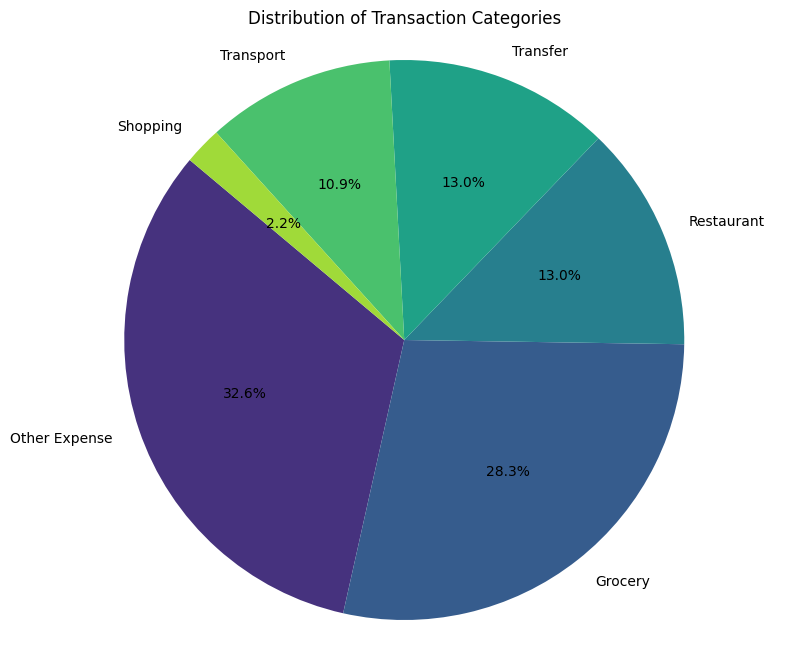

In [52]:
category_counts = df_transactions_processed['Category'].value_counts()

plt.figure(figsize=(10, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(category_counts)))
plt.title('Distribution of Transaction Categories')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Category-wise summary of Debits and Credits:
| Category      |   Total_Debits |   Total_Credits |
|:--------------|---------------:|----------------:|
| Grocery       |          46.64 |            0    |
| Other Expense |         120.08 |            0    |
| Restaurant    |          45.39 |            0    |
| Shopping      |          37.98 |            0    |
| Transfer      |          38.6  |         1673.99 |
| Transport     |          25.5  |            0    |


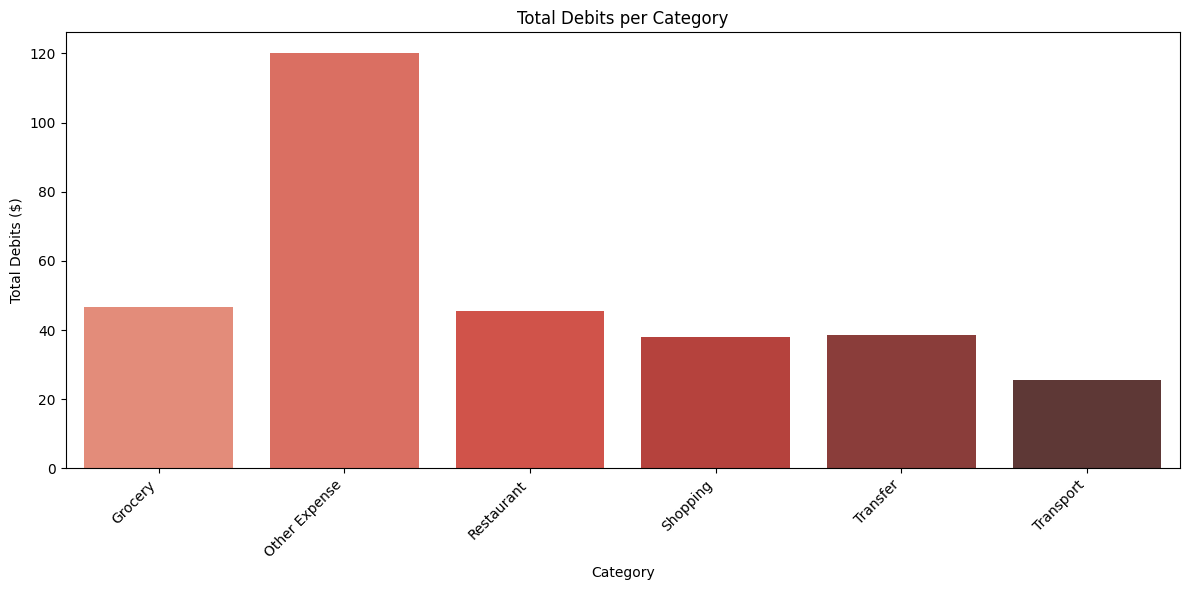

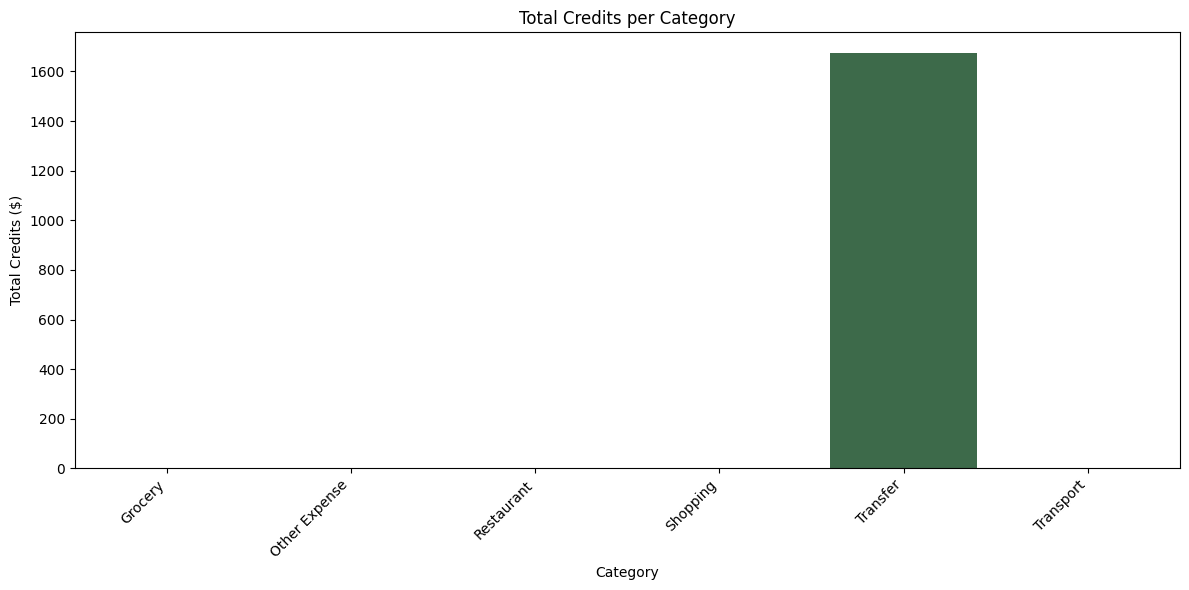

In [54]:
category_summary = df_transactions_processed.groupby('Category').agg(
    Total_Debits=('Debits', 'sum'),
    Total_Credits=('Credits', 'sum')
).fillna(0).reset_index()

print("Category-wise summary of Debits and Credits:")
print(category_summary.to_markdown(index=False))

# Create a bar chart for total Debits per category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Total_Debits', data=category_summary, palette='Reds_d', hue='Category', legend=False)
plt.title('Total Debits per Category')
plt.xlabel('Category')
plt.ylabel('Total Debits ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a bar chart for total Credits per category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Total_Credits', data=category_summary, palette='Greens_d', hue='Category', legend=False)
plt.title('Total Credits per Category')
plt.xlabel('Category')
plt.ylabel('Total Credits ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()